### About
- This notebook is an implementation of the following papers.
    - [Depth Map Prediction from a Single Image using a Multi-Scale Deep Network](https://arxiv.org/pdf/1406.2283.pdf) by Eigen et al., NIPS 2014
- Dataset
    - [NYU Depth Dataset V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)

In [89]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Function
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import time

plt.style.use('seaborn-darkgrid')

%matplotlib inline

### Device configuration

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyper parameters

In [83]:
num_epochs = 20 # not specified in paper
batch_size = 32

### Dataset loader

### Network definition

In [84]:
class GlobalCoarseNet(nn.Module):
    
    def __init__(self):
        super(GlobalCoarseNet, self).__init__()
        
        self.coarse1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        self.coarse2 = nn.Sequential(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        
        self.coarse3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), 
                                     nn.ReLU())
        
        self.coarse4 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), 
                                     nn.ReLU())
        
        self.coarse5 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=2), 
                                     nn.ReLU())
        
        self.coarse6 = nn.Sequential(nn.Linear(in_features=256 * 8 * 6, out_features=4096), 
                                     nn.ReLU(), nn.Dropout(0.5))
        
        self.coarse7 = nn.Linear(in_features=4096, out_features=74 * 55)
        
    
    def forward(self, x):
        x = self.coarse1(x)
        x = self.coarse2(x)
        x = self.coarse3(x)
        x = self.coarse4(x)
        x = self.coarse5(x)
        x = x.reshape(x.size(0), -1)
        x = self.coarse6(x)
        x = self.coarse7(x)
        x = x.reshape(x.size(0), 74, 55)
        return x

class LocalFineNet(nn.Module):
    
    def __init__(self):
        super(LocalFineNet, self).__init__()
        
        self.fine1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=63, kernel_size=9, stride=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        
        self.fine2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2), 
                                   nn.ReLU())
        
        self.fine3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
    
    def forward(self, x, global_output_batch):
        x = self.fine1(x)
        x = torch.cat((x, global_output_batch), dim=1)
        x = self.fine2(x)
        x = self.fine3(x)
        
        return x

# initialize
global_model = GlobalCoarseNet().to(device)
local_model = LocalFineNet().to(device)

### Loss and optimizer
- Reference
    - [Per-parameter options](https://pytorch.org/docs/stable/optim.html)

In [85]:
class ScaleInvariantLoss(nn.Module):
    def __init__(self):
        super(ScaleInvariantLoss, self).__init__()

    def forward(self, pred, target):
        
        dist = pred - target
        
        # the lambda parameter is set to 0.5
        loss = torch.mean(dist ** 2) - 0.5 / ((torch.numel(dist)) ** 2) * (torch.sum(dist) ** 2) 
        
        return loss

# loss
global_criterion = ScaleInvariantLoss()
local_criterion = ScaleInvariantLoss()

# optimizer
r=1
global_optimizer = torch.optim.SGD([{'params': global_model.coarse6.parameters(), 'lr': 0.1*r},
                                    {'params': global_model.coarse7.parameters(), 'lr': 0.1*r}], 
                                   lr=0.001*r, momentum=0.9)

local_optimizer = torch.optim.SGD([{'params': local_model.fine2.parameters(), 'lr': 0.01*r}], 
                                  lr=0.001*r, momentum=0.9)

# data parallel
global_model = nn.DataParallel(global_model)
local_model = nn.DataParallel(local_model)

### Plot gradient flow and losses
- Reference
    - [plot function](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/7)
    - [get gradient of each layer](https://discuss.pytorch.org/t/how-to-calculate-gradient-for-each-layer/1595/4)

In [86]:
def plot_grad_flow(layers, avg_grads):        
    
    for avg_grad in avg_grads:
        plt.plot(avg_grad, alpha=0.3, color="b")
        
    plt.hlines(0, 0, len(layers)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(layers), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(layers))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

def plot_losses(losses):
    plt.plot(losses, alpha=0.3, color="b")
    plt.xlabel("Iterations")
    plt.ylabel("Losses")
    plt.title("Losses")
    plt.grid(True)
    

### Train the global coarse model

time used:  12.128998279571533


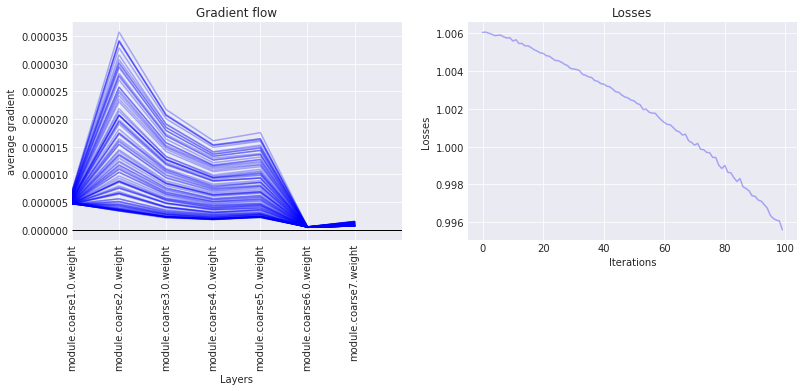

In [87]:
figsize(13, 4)

a = torch.randn(batch_size, 3, 304, 228)
a = a.to(device)

target = torch.randn(batch_size, 74, 55)
target = target.to(device)

losses = []
avg_grads = []
start = time.time()
for i in range(100):
    # forward pass
    output = global_model(a)
    loss = global_criterion(output, target)
    losses.append(loss.item())
    
    # backward pass
    global_model.zero_grad()
    loss.backward()
    
    # avarage gradient
    avg_grad = []
    for n, p in global_model.named_parameters():
        if 'bias' in n:
            continue
        avg_grad.append(p.grad.abs().mean())
    avg_grads.append(avg_grad)
    
    # optimization
    global_optimizer.step()
    
    #print('loss at {} is {}'.format(i + 1, loss))

elapse = time.time() - start 
print('time used: ', elapse)    

plt.subplot(121)
layers = [k for k in global_model.state_dict().keys() if 'bias' not in k]
plot_grad_flow(layers, avg_grads)
    
plt.subplot(122)
plot_losses(losses)


### Train the local fine model

time used:  2.8440229892730713


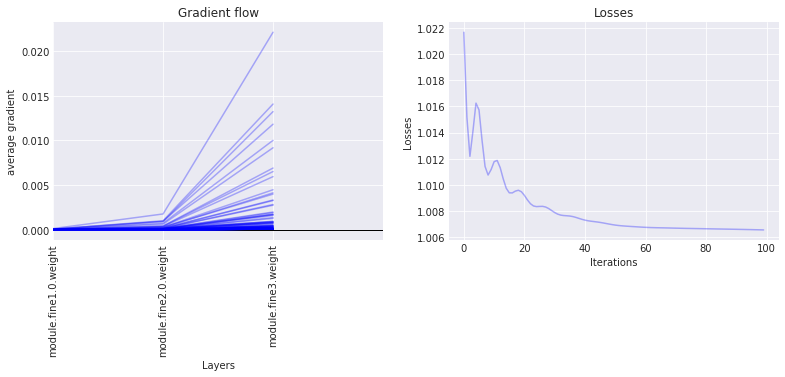

In [88]:
global_model.eval()
with torch.no_grad():
    global_output = global_model(a).unsqueeze(1)

avg_grads = []
losses = []
start = time.time()
for i in range(100):
    
    # forward pass
    output = local_model(a, global_output)
    loss = local_criterion(output, target)
    losses.append(loss.item())
    
    # backward pass
    local_model.zero_grad()
    loss.backward()
    
    
    # avarage gradient
    avg_grad = []
    for n, p in local_model.named_parameters():
        if 'bias' in n:
            continue
        avg_grad.append(p.grad.abs().mean())
    avg_grads.append(avg_grad)
    
    local_optimizer.step()
    
    #print('loss at {} is {}'.format(i + 1, loss))

elapse = time.time() - start
print('time used: ', elapse) 
    
plt.subplot(121)
layers = [k for k in local_model.state_dict().keys() if 'bias' not in k]
plot_grad_flow(layers, avg_grads)

plt.subplot(122)
plot_losses(losses)

